<a href="https://colab.research.google.com/github/Dopamine-Max/FFN-Milestone-projects/blob/main/KNN%26ANN_Missing_Data_Interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries

#for DL modeling
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset

#for ML models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

#for number-crunching
import numpy as np
import scipy.stats as stats

#for dataset management
import pandas as pd
import copy

#for data visualization
import matplotlib.pyplot as plt

In [ ]:
# import and process the data

#import the data
url = "https://drive.google.com/uc?id=1r_suZP4KhNxR05J68Qk9m3z4xl5kFvla"
data = pd.read_csv(url)

# save a pre zscore copy
dataUZ = copy.deepcopy ( data )

# z-score all columns
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('target')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# save a copy of the data (because we'll replace some values with nan's below)
dataOrig = copy.deepcopy( data )

#pick rows to NaN and replace the residual sugar column
# np.random.seed(42)
whichVals2NaN = np.random.choice(range(len(data)),size=300,replace=False)
data['chol'][whichVals2NaN] = np.nan

# for splitting the data, it will be helpful to have a vector of all real-valued rows since we will splitting according to NaN and not with train_test_split
whichValsNotNan = np.where(~data['chol'].isna())[0]
data

<ipython-input-18-54ebe9d75c4f>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['chol'][whichVals2NaN] = np.nan


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,-0.268437,0.661504,-0.915755,-0.377636,-0.659332,-0.418878,0.891255,0.821321,-0.712287,-0.060888,0.995433,1.209221,1.089852,0
1,-0.158157,0.661504,-0.915755,0.479107,NaN,2.387330,-1.004049,0.255968,1.403928,1.727137,-2.243675,-0.731971,1.089852,0
2,1.716595,0.661504,-0.915755,0.764688,-1.396233,-0.418878,0.891255,-1.048692,1.403928,1.301417,-2.243675,-0.731971,1.089852,0
3,0.724079,0.661504,-0.915755,0.936037,-0.833861,-0.418878,0.891255,0.516900,-0.712287,-0.912329,0.995433,0.238625,1.089852,0
4,0.834359,-1.511706,-0.915755,0.364875,NaN,2.387330,0.891255,-1.874977,-0.712287,0.705408,-0.624121,2.179817,-0.522122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,0.503520,0.661504,0.055931,0.479107,NaN,-0.418878,0.891255,0.647366,1.403928,-0.912329,0.995433,-0.731971,-0.522122,1
1021,0.613800,0.661504,-0.915755,-0.377636,0.232705,-0.418878,-1.004049,-0.352873,1.403928,1.471705,-0.624121,0.238625,1.089852,0
1022,-0.819834,0.661504,-0.915755,-1.234378,0.562371,-0.418878,-1.004049,-1.353113,1.403928,-0.060888,-0.624121,0.238625,-0.522122,0
1023,-0.488996,-1.511706,-0.915755,-1.234378,0.155137,-0.418878,-1.004049,0.429923,-0.712287,-0.912329,0.995433,-0.731971,-0.522122,1


In [ ]:
#KNN performance before interpolation

X_knn = dataOrig.drop('target', axis=1)
y_knn = dataOrig['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

# Create the KNN model
k = 3  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")
print(f"F1 Score: {f1:}")

Accuracy: 0.9365853658536586
Precision: 0.9245283018867925
Recall: 0.9514563106796117
F1 Score: 0.9377990430622011


In [ ]:
# Reorganize data into DataLoaders

#vector with residual sugar dropped, for training data
cols2keep = data.keys()
cols2keep = cols2keep.drop('chol')

#extract dataframes to Tensors
train_dataT = torch.tensor(data[cols2keep].values).float()
train_dataT = train_dataT[whichValsNotNan,:]
train_labelsT = torch.tensor(data['chol'].values).float()
train_labelsT = train_labelsT[whichValsNotNan,None] # the 'None' is to transform the matrix

# same for TEST tensors
test_dataT  = torch.tensor( dataOrig[cols2keep].values ).float()
test_dataT  = test_dataT[whichVals2NaN,:]
test_labelsT = torch.tensor( dataOrig['chol'].values ).float()
test_labelsT = test_labelsT[whichVals2NaN,None] # the 'None' is transform to matrix

#convert them into Pytorch dataset
train_dataDataset = TensorDataset(train_dataT,train_labelsT)

# finally, translate into dataloader objects
batchsize  = 32
train_data = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)

# note: we don't need a TEST dataloader; we'll just pass along the test tensor after training

In [ ]:
# create the model

HeartNet = nn.Sequential(
    #input
    nn.Linear(13,32),
    nn.ReLU(),
    #hidden
    nn.Linear(32,64),
    nn.ReLU(),
    nn.Linear(64,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    #output
    nn.Linear(64,1)
)

#loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(HeartNet.parameters(),lr=.01)

In [ ]:
# function that trains the model

def trainTheModel():

  epochs = 1000

  #initialize losses
  losses = torch.zeros(epochs)

  #loop over epochs
  for epochi in range(epochs):

    #loop over training data batches
    batchLoss = []
    for X,y in train_data:

      #forward pass and loss
      yHat = HeartNet(X)
      loss = loss_func(yHat,y)

      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      #loss from this batch
      batchLoss.append(loss.item())
    #end of batch loop...

    #get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

  #function output
  return losses

In [ ]:
# train the model and get predictions
losses = trainTheModel()
yHatTrain = HeartNet(train_dataT)
yHatTest  = HeartNet(test_dataT)

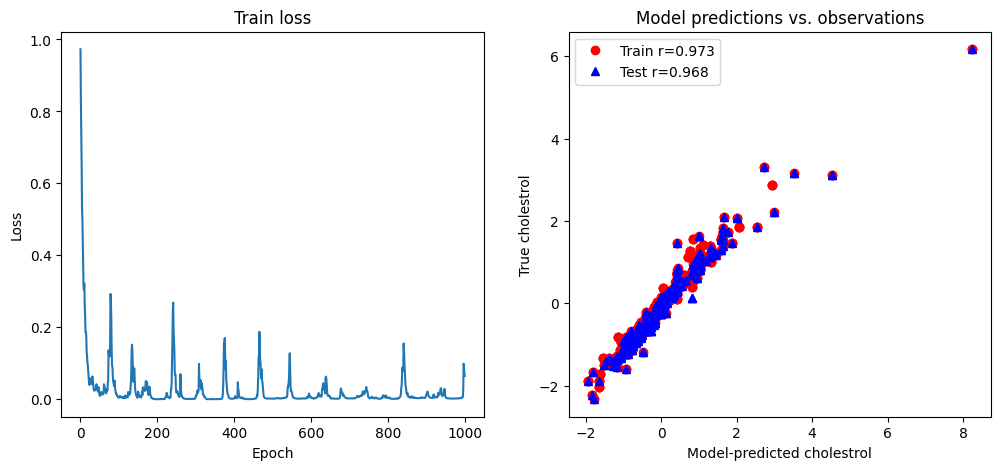

In [ ]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(losses)
ax[0].set_title('Train loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')


ax[1].plot(yHatTrain.detach(),train_labelsT,'ro')
ax[1].plot(yHatTest.detach(),test_labelsT,'b^')
ax[1].set_xlabel('Model-predicted cholestrol')
ax[1].set_ylabel('True cholestrol')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labelsT.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labelsT.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()

In [ ]:
# replace the NaN with model predicted values
data.loc[whichVals2NaN, 'chol'] = yHatTest.detach().numpy().flatten()

In [ ]:
data.loc[whichVals2NaN, 'chol']

125    -0.056817
1017    0.844773
871     0.423355
684    -0.470372
219     0.928900
          ...   
820    -0.644962
241    -0.351144
709     0.423355
629     0.867313
822     0.815973
Name: chol, Length: 300, dtype: float64

In [ ]:
dataOrig.loc[whichVals2NaN, 'chol']

125    -0.116353
1017    0.698116
871     1.454409
684    -1.182919
219     0.775685
          ...   
820    -0.756293
241    -0.659332
709     0.349058
629     0.698116
822     0.135745
Name: chol, Length: 300, dtype: float64

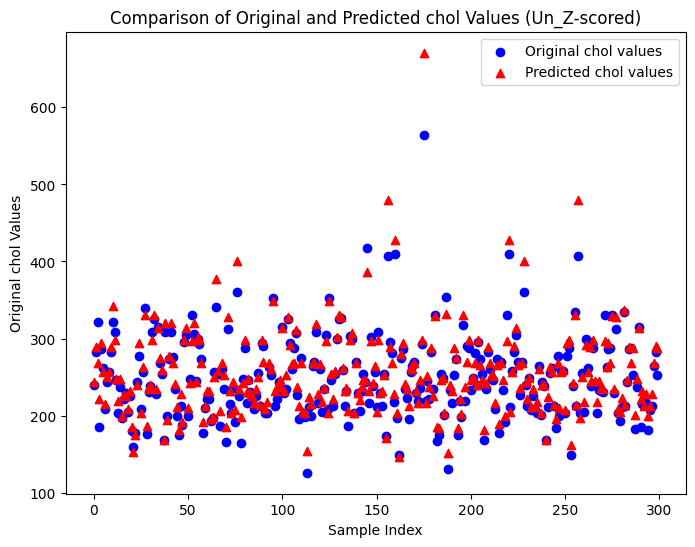

In [ ]:
# Plot the original and imputed chol values

original_mean_chol = dataUZ['chol'].mean() # Original mean before z-score normalization
original_std_chol = dataUZ['chol'].std() # Original standard deviation before z-score normalization

original_zscore_chol = dataOrig.loc[whichVals2NaN, 'chol']
predicted_zscore_chol = data.loc[whichVals2NaN, 'chol']

# Undo z-score normalization
original_chol_values = original_zscore_chol * original_std_chol + original_mean_chol
predicted_chol_values = predicted_zscore_chol * original_std_chol + original_mean_chol

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(range(len(original_chol_values)), original_chol_values, label="Original chol values", color='b', marker='o')
plt.scatter(range(len(predicted_chol_values)), predicted_chol_values, label="Predicted chol values", color='r', marker='^')

plt.xlabel("Sample Index")
plt.ylabel("Original chol Values")
plt.title("Comparison of Original and Predicted chol Values ")
plt.legend()

plt.show()

In [ ]:
 #KNN performance after interpolation

X_knn = data.drop('target', axis=1)
y_knn = data['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

# Create the KNN model
k = 3  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:}")
print(f"Precision: {precision:}")
print(f"Recall: {recall:}")
print(f"F1 Score: {f1:}")

Accuracy: 0.9317073170731708
Precision: 0.9238095238095239
Recall: 0.941747572815534
F1 Score: 0.9326923076923078


In [ ]:
# !apt-get -qq install -y graphviz && pip install pydot

In [ ]:
# %pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master

In [ ]:
# # Visualising Model Architecture

# from torch.autograd import Variable
# import torch.onnx
# from torchviz import make_dot

# # Create a random input tensor with the correct shape
# example_input = Variable(torch.randn(1, 13))

# # Assuming your model is named 'HeartNet'
# dot = make_dot(HeartNet(example_input), params=dict(HeartNet.named_parameters()))
# dot.format = 'png'  # Set the format you want (e.g., 'png', 'pdf')
# dot.render('ann_architecture')  # This will create a file named 'ann_architecture.png'
